# AV Loan Prediction - Analysis

In this notebook, we build and test several classification models against the training dataset. After choosing the best model, we run that against the test data & upload the same to AV website. **This notebook should be run only after the pre-processing has been done.** Preprocessing notbook file can be opened [here](AV Loan Prediction - Data Preprocessing.ipynb).

### 1. Imports & Tweaks

In [84]:
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pprint

Pretty printing has been turned OFF


In [85]:
# Numpy/Pandas & Seaborn tweaks
pd.set_option('display.notebook_repr_html',True)
pd.set_option('display.max_rows',25)
pd.set_option('display.max_columns',25)
pd.set_option('display.width',1024)
# force all Numpy & Pandas floating point output to 3 decimal places
float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.set_option('display.float_format', float_formatter)
# force Numpy to display very small floats using floating point notation
np.set_printoptions(threshold=np.inf, suppress=True, precision=4, linewidth=2048)
# force GLOBAL floating point output to 4 decimal places
%precision 4

# tweaks for Seaborn plotting library
plt.style.use('seaborn-muted')
sns.set_style('whitegrid')
sns.set_style({'font.sans-serif':['Verdana','Arial','Calibri','DejaVu Sans']})
sns.set_context('talk')

seed = 42
np.random.seed(seed)

### 2. Load Data & View some Plots

In [86]:
data_file = './data/loan_prediction_train_data_cleaned.csv'
loans_df = pd.read_csv(data_file, index_col=0)
loans_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,ApplicantIncome_Log,CoapplicantIncome_Log,TotalIncome_Log,LoanAmount_Log,Property_Area_Semiurban,Property_Area_Urban
Loan_ID,,,,,,,,,,,,,,,,,,
LP001002,1,0,0,0,0,5849,0.0000,130.0000,360.0000,1,1,5849.0000,8.6740,0.0000,8.6740,4.8675,0,1
LP001003,1,1,1,0,0,4583,1508.0000,128.0000,360.0000,1,0,6091.0000,8.4301,7.3185,8.7146,4.8520,0,0
LP001005,1,1,0,0,1,3000,0.0000,66.0000,360.0000,1,1,3000.0000,8.0064,0.0000,8.0064,4.1897,0,1
LP001006,1,1,0,1,0,2583,2358.0000,120.0000,360.0000,1,1,4941.0000,7.8567,7.7656,8.5053,4.7875,0,1
LP001008,1,0,0,0,0,6000,0.0000,141.0000,360.0000,1,1,6000.0000,8.6995,0.0000,8.6995,4.9488,0,1


In [87]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 18 columns):
Gender                     614 non-null int64
Married                    614 non-null int64
Dependents                 614 non-null int64
Education                  614 non-null int64
Self_Employed              614 non-null int64
ApplicantIncome            614 non-null int64
CoapplicantIncome          614 non-null float64
LoanAmount                 614 non-null float64
Loan_Amount_Term           614 non-null float64
Credit_History             614 non-null int64
Loan_Status                614 non-null int64
TotalIncome                614 non-null float64
ApplicantIncome_Log        614 non-null float64
CoapplicantIncome_Log      614 non-null float64
TotalIncome_Log            614 non-null float64
LoanAmount_Log             614 non-null float64
Property_Area_Semiurban    614 non-null int64
Property_Area_Urban        614 non-null int64
dtypes: float64(8), int64(10)
memory usage: 

In [88]:
loans_df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,ApplicantIncome_Log,CoapplicantIncome_Log,TotalIncome_Log,LoanAmount_Log,Property_Area_Semiurban,Property_Area_Urban
count,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000,614.0000
mean,0.8176,0.6531,0.7443,0.2182,0.1336,5403.4593,1621.2458,145.7647,342.4104,0.8550,0.6873,7024.7051,8.3412,4.2897,8.6694,4.8571,0.3795,0.3290
std,0.3865,0.4764,1.0096,0.4134,0.3404,6109.0417,2926.2484,84.1457,64.4286,0.3523,0.4640,6458.6639,0.6453,3.8757,0.5451,0.4964,0.4857,0.4702
min,0.0000,0.0000,0.0000,0.0000,0.0000,150.0000,0.0000,9.0000,12.0000,0.0000,0.0000,1442.0000,5.0106,0.0000,7.2738,2.1972,0.0000,0.0000
25%,1.0000,0.0000,0.0000,0.0000,0.0000,2877.5000,0.0000,100.2500,360.0000,1.0000,0.0000,4166.0000,7.9647,0.0000,8.3347,4.6077,0.0000,0.0000
50%,1.0000,1.0000,0.0000,0.0000,0.0000,3812.5000,1188.5000,128.0000,360.0000,1.0000,1.0000,5416.5000,8.2460,7.0803,8.5972,4.8520,0.0000,0.0000
75%,1.0000,1.0000,1.0000,0.0000,0.0000,5795.0000,2297.2500,164.7500,360.0000,1.0000,1.0000,7521.7500,8.6647,7.7395,8.9255,5.1044,1.0000,1.0000
max,1.0000,1.0000,3.0000,1.0000,1.0000,81000.0000,41667.0000,700.0000,480.0000,1.0000,1.0000,81000.0000,11.3022,10.6375,11.3022,6.5511,1.0000,1.0000


In [89]:
# just confirming that we don't have any NULLS
loans_df.isnull().sum()

Gender                     0
Married                    0
Dependents                 0
Education                  0
Self_Employed              0
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Loan_Status                0
TotalIncome                0
ApplicantIncome_Log        0
CoapplicantIncome_Log      0
TotalIncome_Log            0
LoanAmount_Log             0
Property_Area_Semiurban    0
Property_Area_Urban        0
dtype: int64

In [90]:
# save the features & target_col for use
columns = loans_df.columns.values
columns, type(columns)

(array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'TotalIncome', 'ApplicantIncome_Log', 'CoapplicantIncome_Log', 'TotalIncome_Log', 'LoanAmount_Log', 'Property_Area_Semiurban', 'Property_Area_Urban'], dtype=object), <class 'numpy.ndarray'>)

In [91]:
# we will use only the following cols for our analysis
selected_cols = ['Gender','Married','Dependents','Education','Self_Employed','Loan_Amount_Term','Credit_History',
                 'TotalIncome','LoanAmount','Property_Area_Semiurban','Property_Area_Urban','Loan_Status']
target_col = 'Loan_Status'
features = selected_cols[:-1]
features, target_col

(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanAmount', 'Property_Area_Semiurban', 'Property_Area_Urban'], 'Loan_Status')

In [92]:
data_df = loans_df[selected_cols]

In [93]:
len(data_df), len(features)

(614, 11)

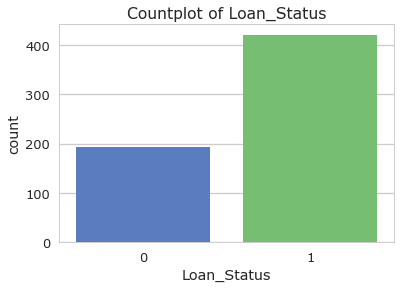

In [94]:
# plot distribution of target_col
# how is the outcome distributed?
f, ax = plt.subplots(figsize=(6,4))
sns.countplot(x=target_col,data=data_df,ax=ax)
plt.title('Countplot of %s' % target_col)
plt.show()
plt.close()

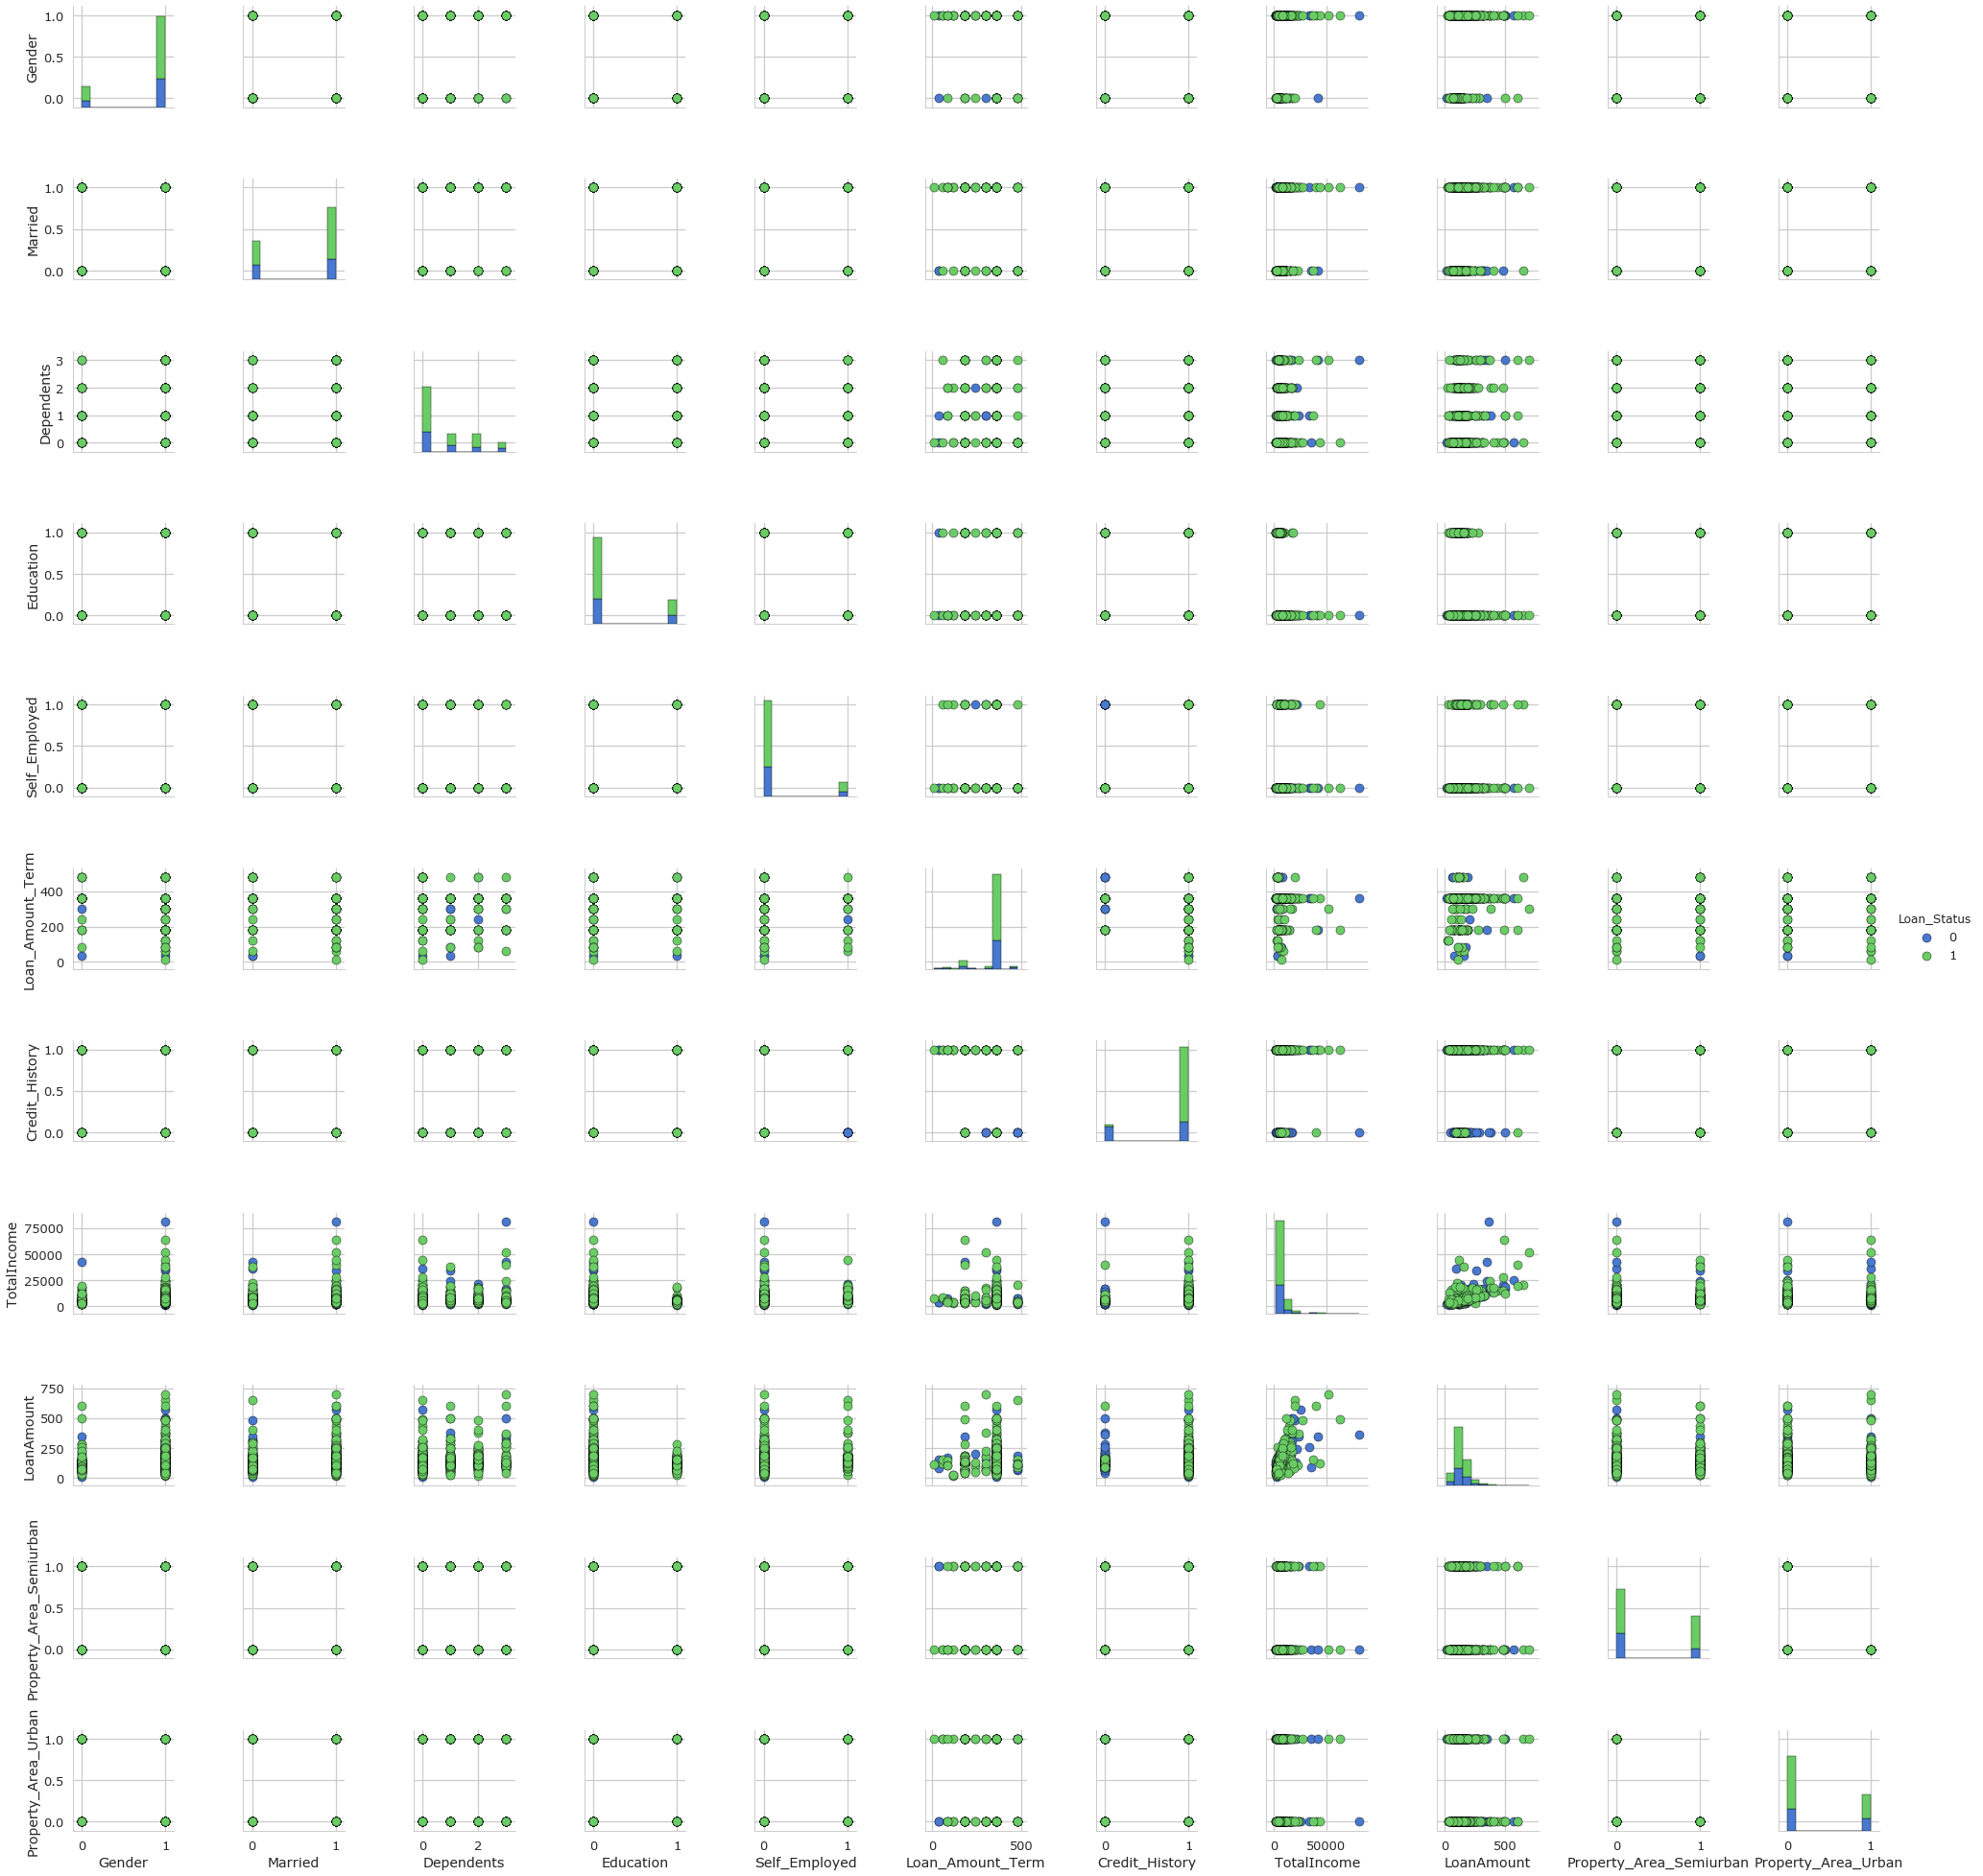

In [95]:
# Pairplot of all features
g = sns.PairGrid(data_df, vars=features, hue=target_col, size=2.5)
g.map_diag(plt.hist,edgecolor='k')
g.map_upper(plt.scatter, edgecolor='k')
g.map_lower(plt.scatter, edgecolor='k')
g.add_legend()
plt.show()
plt.close()

**Observation:**
* Does not appear to be useful in determing any separating boundary between the loan status.

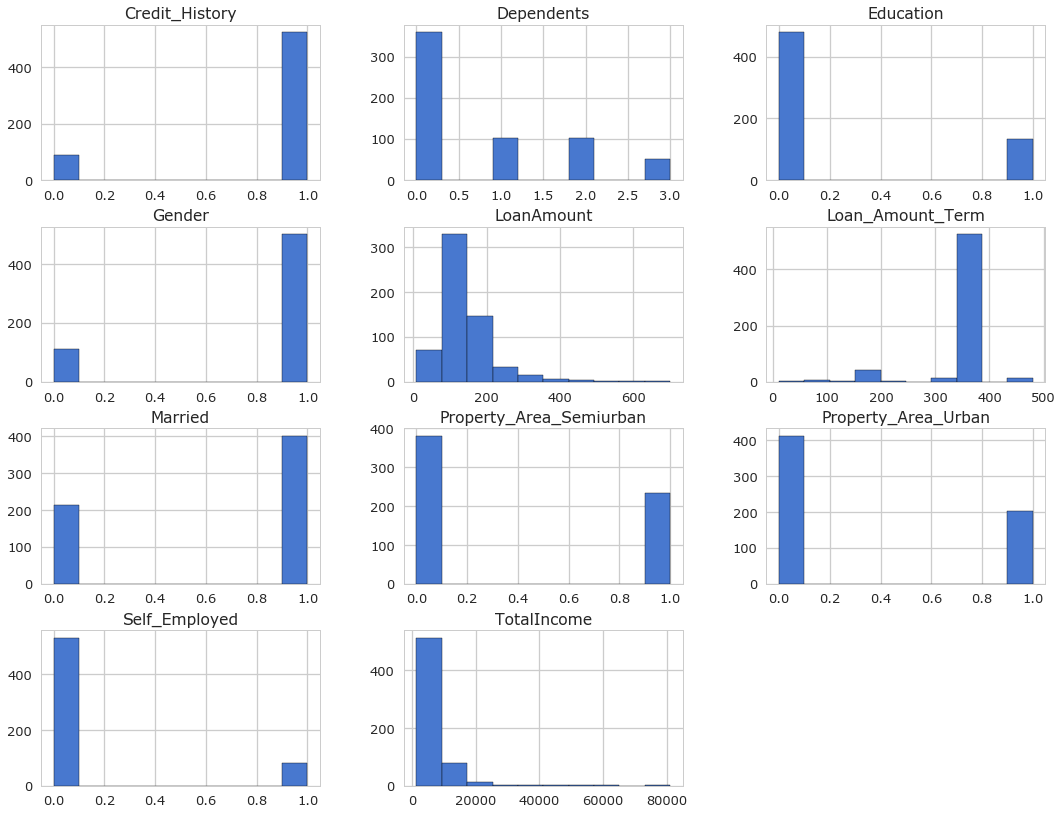

In [96]:
# histogram of distribution of each feature (not very clear in PairPlot)
_ = data_df[features].hist(edgecolor='k',grid=True, figsize=(18,14))
plt.show()
plt.close()

### **Observations & Actions:**
* We have an imbalanced outcome variable (*Loan_Status*) - the Approved (1) status are ~50% more than the Denied (0) status
    > _Action:_ We will attempt to address this by:
    * Using stratified selection when we split data into train/test sets 
    * Using ROC-AUC as performance measure, rather than accuracy 
    * Using balanced weigthing for all features and 
    * Up-sampling the minor category to rectify the imbalance.
* We have 614 observations (samples) in the dataset and 11 features 
    > _Action:_ 
    * There are too many features viz-a-viz no. of samples (as an emperical rule, we should have at least 100 records per feature, so we should have at lest 11000 training records). 
    * We will have to apply feature selection techniques to select N best features. We could use PCA techniques & select 5 best features.
* Features appear to be measured on different scales.
    > _Action:_ 
    * Standardization (Standard scaling) would help. We can use this in a `Pipeline()` object

#### Split data into train/test sets

In [97]:
# split the data into train/test sets
from sklearn.model_selection import train_test_split

# now we will do an 80:20 train/test split on the oversampled dataset (data_df2)
train_set, test_set = \
  train_test_split(data_df, test_size=0.20, random_state=0,stratify=data_df[target_col])
# NOTE: X_train, X_test are DataFranmes & y_train, y_test are Series objects!!
X_train = train_set[features]
X_test = test_set[features]
y_train = train_set[target_col]
y_test = test_set[target_col]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(491, 11) (123, 11) (491,) (123,)


In [98]:
# scale the data - scaling helps most classification algos perform faster
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

### 3. Data Analysis - Running models on the datasets

#### Some Utility Functions

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score 
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, f1_score

In [100]:
def do_kfold_cv(classifier, X_train, y_train, n_splits=10, scoring='roc_auc'):
    """ do a k-fold cross validation run on classifier & training data
      and return cross-val scores """   
    kfolds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cv_scores = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=kfolds)
    return cv_scores

def test_classifier(classifier, classifier_name, X_train, y_train, X_test, y_test, n_folds=10, scoring='roc_auc', verbose=2):
    """ run a k-fold test, fit model to training data & report
        scores for training & test data """
    # extract classifier instance & name
    #classifier, classifier_name = clf_tuple
   
    if verbose > 0:
        print('Testing %s...' % classifier_name)
    
    classifier.fit(X_train, y_train)
    
    # accuracy scores, against test data
    acc_score_train = classifier.score(X_train, y_train)
    acc_score_test = classifier.score(X_test, y_test)
    
    # k-fold cross-validation scores
    #cv_scores = do_kfold_cv(classifier, X_train, y_train, scoring=scoring)
    cv_scores = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=n_folds)

    # roc-auc score
    y_pred_proba_train = classifier.predict_proba(X_train)[:,1]
    y_pred_proba_test = classifier.predict_proba(X_test)[:,1]
    auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    auc_score_test = roc_auc_score(y_test, y_pred_proba_test)
    
    # f1-score
    f1_score_train = f1_score(y_train, classifier.predict(X_train))
    f1_score_test = f1_score(y_test, classifier.predict(X_test))

    if verbose > 1:   
        print('   - cross-val score        : Mean - %.3f Std - %.3f Min - %.3f Max - %.3f' % \
                  (np.mean(cv_scores), np.std(cv_scores), np.min(cv_scores), np.max(cv_scores)))
        print('   - accuracy score (train) : %.3f' % (acc_score_train))
        print('   - accuracy score (test)  : %.3f **' % (acc_score_test))
        print('   - AUC score (train)      : %.3f' % (auc_score_train))
        print('   - AUC score (test)       : %.3f **' % (auc_score_test))
        print('   - F1 score (train)       : %.3f' % (f1_score_train))
        print('   - F1 score (test)        : %.3f **' % (f1_score_test))
              
    return cv_scores, acc_score_train, acc_score_test, auc_score_train, auc_score_test, f1_score_train, f1_score_test

def test_classifiers(clf_list, X_train, y_train, X_test, y_test, n_folds=10, scoring='roc_auc', verbose=2):
    """ run a list of classifiers against the training & test sets and
        return a pandas DataFrame of scores """
    classifier_names = []
    clf_cv_scores = []
    clf_acc_scores_train = []
    clf_acc_scores_test = []
    clf_auc_scores_train = []
    clf_auc_scores_test = []
    clf_f1_scores_train = []
    clf_f1_scores_test = []
    
    for classifier_name, classifier in clf_list.items():
        cv_scores, acc_score_train, acc_score_test, auc_score_train, auc_score_test, f1_score_train, f1_score_test = \
            test_classifier(classifier, classifier_name, X_train, y_train, X_test, y_test, 
                            n_folds=n_folds, scoring=scoring, verbose=verbose)
                
        #classifier, classifier_name = clf_tuple
        classifier_names.append(classifier_name)
        clf_cv_scores.append(np.mean(cv_scores))
        clf_acc_scores_train.append(acc_score_train)
        clf_acc_scores_test.append(acc_score_test)
        
        clf_auc_scores_train.append(auc_score_train)   
        clf_auc_scores_test.append(auc_score_test)
        
        clf_f1_scores_train.append(f1_score_train)
        clf_f1_scores_test.append(f1_score_test)
   
    # now create a DataFrame of all the scores & return
    scores_df = pd.DataFrame(data=clf_cv_scores, index=classifier_names,
                             columns=['mean_cv_scores'])
    scores_df['accuracy_train'] = clf_acc_scores_train
    scores_df['accuracy_test'] = clf_acc_scores_test
    scores_df['AUC_train'] = clf_auc_scores_train
    scores_df['AUC_test'] = clf_auc_scores_test
    scores_df['f1score_train'] = clf_f1_scores_train
    scores_df['f1score_test'] = clf_f1_scores_test
    
    return scores_df

In [101]:
# now let's run a set of classifiers against the data
# for linear classifiers, we will standardise the data using StandardScaler()
# we will do  this in a Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# ensemble classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [102]:
# instantiate the classifiers - we are using several classifiers - and append to classifier list (clf_list)
def get_classifiers(n_comps=5):
    clf_list = {}
    N_COMPS = (len(features) if n_comps is None else n_comps)
    
    if ((N_COMPS < 1) | (N_COMPS > len(features))):
        raise ValueError('n_comps is out of range! Expecting value between 1 and %d' % len(features))

    # KNN classifier
    pipe_knn = Pipeline([('pca', PCA(n_components=N_COMPS)),
                         ('clf', KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski'))])
    #clf_list.append((pipe_knn, 'KNN Classifier'))
    clf_list['KNN Classifier'] = pipe_knn

    # Logistic Regression classifier
    pipe_lr = Pipeline([('pca', PCA(n_components=N_COMPS)),
                        ('clf', LogisticRegression(penalty='l2', tol=0.0001, C=1.0, class_weight='balanced', 
                                                   random_state=seed))])
    #clf_list.append((pipe_lr, 'LogisticRegression Classifier'))
    clf_list['LogisticRegression Classifier'] = pipe_lr

    # SVC (Linear) classifier
    pipe_svcl = Pipeline([('pca', PCA(n_components=N_COMPS)),
                          ('clf', SVC(kernel='linear', C=1.0, gamma='auto', class_weight='balanced', 
                                      probability=True, random_state=seed))])
    #clf_list.append((pipe_svcl, 'SVC(Linear) Classifier'))
    clf_list['SVC(Linear) Classifier'] = pipe_svcl

    # SVC (Gaussian) classifier
    pipe_svcg = Pipeline([('pca', PCA(n_components=N_COMPS)),
                          ('clf', SVC(kernel='rbf',C=1.0, gamma='auto', class_weight='balanced', 
                                      probability=True, random_state=seed))])
    #clf_list.append((pipe_svcg, 'SVC(Gaussian) Classifier'))
    clf_list['SVC(Gaussian) Classifier'] = pipe_svcg

    # Naive Bayes - don't really need scaling
    pipe_nb = Pipeline([('pca', PCA(n_components=N_COMPS)),                    
                        ('clf', GaussianNB())])
    #clf_list.append((pipe_nb, 'Naive Bayes Classifier')) 
    clf_list['Naive Bayes Classifier'] = pipe_nb

    # DecisionTree classifier - does not need scaling
    pipe_dt = Pipeline([('pca', PCA(n_components=N_COMPS)),                    
                        ('clf', DecisionTreeClassifier(random_state=seed, criterion='entropy', class_weight='balanced', 
                                                       max_depth=5))])
    #clf_list.append((pipe_dt, 'Decision Tree Classifier'))
    clf_list['Decision Tree Classifier'] = pipe_dt
        
    # Random Forest classifier
    pipe_rfc = Pipeline([('pca', PCA(n_components=N_COMPS)),                    
                         ('clf', RandomForestClassifier(n_estimators=100,  criterion='entropy', max_depth=5, 
                                                        class_weight='balanced', random_state=seed))])
    #clf_list.append((pipe_rfc, 'Random Forests Classifier'))
    clf_list['Random Forests Classifier'] = pipe_rfc
    
    # ExtraTrees classifier
    pipe_xtc = Pipeline([('pca', PCA(n_components=N_COMPS)),                    
                         ('clf', ExtraTreesClassifier(criterion='entropy', max_depth=5, n_estimators=100, 
                                                      class_weight='balanced', random_state=seed))])
    #clf_list.append((pipe_xtc, 'Extra Trees Classifier'))
    clf_list['Extra Trees Classifier'] = pipe_xtc
    
    # Voting classifier - since the estimators are already running PCA, no PCA step here!
    estimators = [('lr', pipe_lr), ('dt', pipe_dt), ('knn', pipe_knn), ('svg', pipe_svcg), ('svl', pipe_svcl)]
    clf_vt = VotingClassifier(estimators = estimators,voting='soft')
    #clf_list.append((clf_vt, 'Voting Classifier'))
    clf_list['Voting Classifier'] = clf_vt
    
    # base estimator is an UNPRUNED DecisionTree classifier
    tree = DecisionTreeClassifier(criterion='entropy',max_depth=None, 
                                  class_weight='balanced', random_state=seed)
    
    clf_bgc = BaggingClassifier(base_estimator=tree,   # an unpruned Decision Tree
                                n_estimators=500,      # 500 estimators
                                max_samples=1.0,       # select all rows for random sampling
                                max_features=1.0,      # select all features in each sample
                                bootstrap=True,        # Samples are drawn with replacement
                                bootstrap_features=False, 
                                n_jobs=-1,             # use all cores  
                                random_state=seed)
    pipe_bgc = Pipeline([('pca', PCA(n_components=N_COMPS)),                    
                         ('clf', clf_bgc)])
    #clf_list.append((pipe_bgc, 'Bagging Classifier'))
    clf_list['Bagging Classifier'] = pipe_bgc
    
    # Adaboosting classifier
    stump = DecisionTreeClassifier(criterion='entropy',max_depth=1, class_weight='balanced', random_state=seed)
    clf_abc = AdaBoostClassifier(base_estimator=stump, n_estimators=500, learning_rate=0.1,random_state=seed)  
    pipe_abc = Pipeline([('pca', PCA(n_components=N_COMPS)),                    
                         ('clf', clf_abc)])
    #clf_list.append((pipe_abc, 'AdaBoost Classifier'))
    clf_list['AdaBoost Classifier'] = pipe_abc

    # Gradient boosting classifier    
    clf_gbc = GradientBoostingClassifier(loss='deviance',learning_rate=0.1,n_estimators=500, max_depth=5, random_state=seed)
    #clf_list.append((pipe_gbc, 'Gradient Boosting Classifier'))
    pipe_gbc = Pipeline([('pca', PCA(n_components=N_COMPS)),                    
                         ('clf', clf_gbc)])
    #clf_list.append((pipe_gbc, 'GradientBoosting Classifier'))
    clf_list['GradientBoosting Classifier'] = pipe_gbc
    
    return clf_list

In [103]:
clf_list = get_classifiers()
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
scores_df = test_classifiers(clf_list, X_train_std, y_train, X_test_std, y_test, verbose=2)
print('Done!')

Testing KNN Classifier...
   - cross-val score        : Mean - 0.713 Std - 0.074 Min - 0.557 Max - 0.799
   - accuracy score (train) : 0.811
   - accuracy score (test)  : 0.821 **
   - AUC score (train)      : 0.881
   - AUC score (test)       : 0.792 **
   - F1 score (train)       : 0.874
   - F1 score (test)        : 0.884 **
Testing LogisticRegression Classifier...
   - cross-val score        : Mean - 0.748 Std - 0.068 Min - 0.628 Max - 0.865
   - accuracy score (train) : 0.739
   - accuracy score (test)  : 0.789 **
   - AUC score (train)      : 0.765
   - AUC score (test)       : 0.792 **
   - F1 score (train)       : 0.813
   - F1 score (test)        : 0.847 **
Testing SVC(Linear) Classifier...
   - cross-val score        : Mean - 0.734 Std - 0.079 Min - 0.582 Max - 0.869
   - accuracy score (train) : 0.807
   - accuracy score (test)  : 0.789 **
   - AUC score (train)      : 0.753
   - AUC score (test)       : 0.762 **
   - F1 score (train)       : 0.874
   - F1 score (test)      

/home/mjbhobe/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mjbhobe/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


   - cross-val score        : Mean - 0.731 Std - 0.091 Min - 0.503 Max - 0.861
   - accuracy score (train) : 0.829
   - accuracy score (test)  : 0.797 **
   - AUC score (train)      : 0.887
   - AUC score (test)       : 0.799 **
   - F1 score (train)       : 0.887
   - F1 score (test)        : 0.866 **
Testing Bagging Classifier...


/home/mjbhobe/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mjbhobe/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


   - cross-val score        : Mean - 0.719 Std - 0.069 Min - 0.538 Max - 0.783
   - accuracy score (train) : 1.000
   - accuracy score (test)  : 0.724 **
   - AUC score (train)      : 1.000
   - AUC score (test)       : 0.753 **
   - F1 score (train)       : 1.000
   - F1 score (test)        : 0.811 **
Testing AdaBoost Classifier...
   - cross-val score        : Mean - 0.715 Std - 0.064 Min - 0.600 Max - 0.806
   - accuracy score (train) : 0.851
   - accuracy score (test)  : 0.748 **
   - AUC score (train)      : 0.904
   - AUC score (test)       : 0.733 **
   - F1 score (train)       : 0.895
   - F1 score (test)        : 0.823 **
Testing GradientBoosting Classifier...
   - cross-val score        : Mean - 0.693 Std - 0.061 Min - 0.537 Max - 0.763
   - accuracy score (train) : 1.000
   - accuracy score (test)  : 0.740 **
   - AUC score (train)      : 1.000
   - AUC score (test)       : 0.707 **
   - F1 score (train)       : 1.000
   - F1 score (test)        : 0.824 **
Done!


In [104]:
scores_df.sort_values(by=['AUC_test'], ascending=False, inplace=True)
print('\nClassifiers sorted by AUC Scores [test data] (descending):')
scores_df


Classifiers sorted by AUC Scores [test data] (descending):


,mean_cv_scores,accuracy_train,accuracy_test,AUC_train,AUC_test,f1score_train,f1score_test
SVC(Gaussian) Classifier,0.7250,0.8350,0.7886,0.8358,0.8031,0.8880,0.8523
Random Forests Classifier,0.7312,0.8595,0.7886,0.9369,0.8019,0.9046,0.8571
Voting Classifier,0.7310,0.8289,0.7967,0.8866,0.7988,0.8871,0.8663
KNN Classifier,0.7130,0.8106,0.8211,0.8807,0.7923,0.8745,0.8842
LogisticRegression Classifier,0.7484,0.7393,0.7886,0.7646,0.7916,0.8134,0.8471
Extra Trees Classifier,0.7391,0.8269,0.7561,0.8593,0.7779,0.8837,0.8333
Naive Bayes Classifier,0.7483,0.7841,0.7724,0.7522,0.7706,0.8544,0.8462
SVC(Linear) Classifier,0.7339,0.8065,0.7886,0.7533,0.7619,0.8742,0.8617
Bagging Classifier,0.7192,1.0000,0.7236,1.0000,0.7528,1.0000,0.8111
AdaBoost Classifier,0.7146,0.8513,0.7480,0.9037,0.7327,0.8947,0.8229


We don't see any classifier with AUC score > 85%. This is something we should aspire to improve.

Let's check the confusion matrices of the top 2 classifiers (w.r.t. AUC Score (test)) from above list - the SVC (Gaussian) & the Random Forests classifier.

In [105]:
clf = clf_list['Bagging Classifier'] 
# better way of viewing the confusion matrix - use cross-tab
print('Confusion matrix for %s' % 'Bagging Classifier')
pd.crosstab(y_test.ravel(), clf.predict(X_test_std), rownames=['Actual'], colnames=['Predicted->'], margins=False)

Confusion matrix for Bagging Classifier


Predicted->,0,1
Actual,,
0,16,22
1,12,73


In [106]:
clf = clf_list['SVC(Gaussian) Classifier'] 
# better way of viewing the confusion matrix - use cross-tab
print('Confusion matrix for %s' % 'SVC(Gaussian) Classifier')
pd.crosstab(y_test.ravel(), clf.predict(X_test_std), rownames=['Actual'], colnames=['Predicted->'], margins=False)

Confusion matrix for SVC(Gaussian) Classifier


Predicted->,0,1
Actual,,
0,22,16
1,10,75


We have a lot of _False Positives_ (i.e. predicted = 1, when actual = 0).

We had shown ealier that the `Loan_Status` is imbalanced. We have ~twice as many YES cases as there are NO cases. Our classifiers should benifit if we can provide more balanced training dataset w.r.t. the `Loan_Status` column. 

We will oversample the minority (`Loan_Status == 0`) class rows to match the majority class. We will use `sklearn.utils.resample` helper class to help with this.

In [107]:
from sklearn.utils import resample

# we will re-sample the minority class with replacement so the count matches the majority class
df_minority = data_df.loc[data_df[target_col] == 0]
df_majority = data_df.loc[data_df[target_col] == 1]
len(df_minority), len(df_majority)

df_minority_upsampled = resample(df_minority,
                                 replace=True,      # we need to sample with replacement
                                 n_samples=len(df_majority),  # until no of records in df_minority match those in df_majority
                                 random_state=0)
# now we concatenate df_majority & df_upsamples_minority
data_df2 = pd.concat([df_majority, df_minority_upsampled],axis=0)
data_df2[target_col].value_counts()

1    422
0    422
Name: Loan_Status, dtype: int64

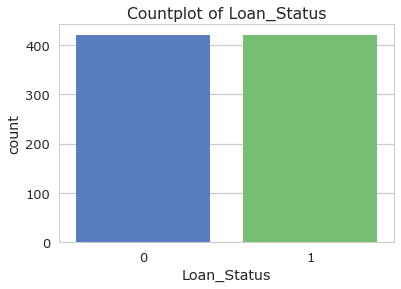

In [108]:
f, ax = plt.subplots(figsize=(6,4))
sns.countplot(x=target_col,data=data_df2,ax=ax)
plt.title('Countplot of %s' % target_col)
plt.show()
plt.close()

This is a much better balanced dataset w.r.t. to the `Loan_Status` column. Now let us split this dataset into train/test sets & repeat the exercise above and check results. Hoping to see much better performance - fingers crossed XXX.

In [109]:
# now re-split into train/test sets (80:20) ratio as before and test on these new sets
train_set2, test_set2 = \
  train_test_split(data_df2, test_size=0.20, random_state=0,stratify=data_df2[target_col])
X_train2 = train_set2[features]
X_test2 = test_set2[features]
y_train2 = train_set2[target_col]
y_test2 = test_set2[target_col]
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

(675, 11) (169, 11) (675,) (169,)


In [110]:
ss = StandardScaler()
X_train_std2 = ss.fit_transform(X_train2)
X_test_std2 = ss.transform(X_test2)

In [111]:
train_set2[target_col].value_counts()

1    338
0    337
Name: Loan_Status, dtype: int64

In [112]:
# now train the same list of classifiers against this augmented data
# NOTE: It is very much possible to see a diffrent result (in terms of ordering) this time around - let's see.
scores_df2 = test_classifiers(clf_list, X_train_std2, y_train2, X_test_std2, y_test2, verbose=2)
print('Done!')

Testing KNN Classifier...
   - cross-val score        : Mean - 0.830 Std - 0.051 Min - 0.733 Max - 0.913
   - accuracy score (train) : 0.837
   - accuracy score (test)  : 0.710 **
   - AUC score (train)      : 0.927
   - AUC score (test)       : 0.799 **
   - F1 score (train)       : 0.835
   - F1 score (test)        : 0.710 **
Testing LogisticRegression Classifier...
   - cross-val score        : Mean - 0.760 Std - 0.051 Min - 0.664 Max - 0.850
   - accuracy score (train) : 0.719
   - accuracy score (test)  : 0.627 **
   - AUC score (train)      : 0.772
   - AUC score (test)       : 0.700 **
   - F1 score (train)       : 0.744
   - F1 score (test)        : 0.640 **
Testing SVC(Linear) Classifier...
   - cross-val score        : Mean - 0.755 Std - 0.043 Min - 0.674 Max - 0.823
   - accuracy score (train) : 0.736
   - accuracy score (test)  : 0.675 **
   - AUC score (train)      : 0.773
   - AUC score (test)       : 0.713 **
   - F1 score (train)       : 0.775
   - F1 score (test)      

/home/mjbhobe/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mjbhobe/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


   - cross-val score        : Mean - 0.838 Std - 0.033 Min - 0.769 Max - 0.893
   - accuracy score (train) : 0.813
   - accuracy score (test)  : 0.710 **
   - AUC score (train)      : 0.915
   - AUC score (test)       : 0.772 **
   - F1 score (train)       : 0.831
   - F1 score (test)        : 0.735 **
Testing Bagging Classifier...


/home/mjbhobe/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mjbhobe/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


   - cross-val score        : Mean - 0.916 Std - 0.031 Min - 0.876 Max - 0.974
   - accuracy score (train) : 1.000
   - accuracy score (test)  : 0.811 **
   - AUC score (train)      : 1.000
   - AUC score (test)       : 0.907 **
   - F1 score (train)       : 1.000
   - F1 score (test)        : 0.789 **
Testing AdaBoost Classifier...
   - cross-val score        : Mean - 0.824 Std - 0.046 Min - 0.730 Max - 0.908
   - accuracy score (train) : 0.801
   - accuracy score (test)  : 0.704 **
   - AUC score (train)      : 0.910
   - AUC score (test)       : 0.786 **
   - F1 score (train)       : 0.823
   - F1 score (test)        : 0.719 **
Testing GradientBoosting Classifier...
   - cross-val score        : Mean - 0.928 Std - 0.030 Min - 0.889 Max - 0.982
   - accuracy score (train) : 1.000
   - accuracy score (test)  : 0.840 **
   - AUC score (train)      : 1.000
   - AUC score (test)       : 0.922 **
   - F1 score (train)       : 1.000
   - F1 score (test)        : 0.832 **
Done!


In [113]:
scores_df2.sort_values(by=['AUC_test'], ascending=False, inplace=True)
print('\nClassifiers sorted by AUC Scores [test data] (descending):')
scores_df2


Classifiers sorted by AUC Scores [test data] (descending):


,mean_cv_scores,accuracy_train,accuracy_test,AUC_train,AUC_test,f1score_train,f1score_test
GradientBoosting Classifier,0.9277,1.0000,0.8402,1.0000,0.9216,1.0000,0.8323
Bagging Classifier,0.9163,1.0000,0.8107,1.0000,0.9073,1.0000,0.7895
Random Forests Classifier,0.8436,0.8459,0.7456,0.9378,0.8025,0.8653,0.7701
KNN Classifier,0.8299,0.8370,0.7101,0.9275,0.7986,0.8353,0.7101
AdaBoost Classifier,0.8243,0.8015,0.7041,0.9098,0.7856,0.8228,0.7191
Voting Classifier,0.8377,0.8133,0.7101,0.9147,0.7720,0.8311,0.7351
SVC(Gaussian) Classifier,0.8071,0.7941,0.6982,0.8639,0.7627,0.8164,0.7273
Decision Tree Classifier,0.7740,0.7837,0.7219,0.8598,0.7414,0.8206,0.7729
Extra Trees Classifier,0.8110,0.7793,0.6627,0.8552,0.7365,0.8062,0.6851
SVC(Linear) Classifier,0.7554,0.7363,0.6746,0.7728,0.7134,0.7753,0.7090


This is a much better result - no? Notice that the top two classifiers have AUC score in the nineties. However notice that the scores for training data is 1.0, which clearly indicates that they are overfitting the data.

Now let us use GridSearchCV to tune the GradientBoosting Classifier - we will focus on `max_depth` and `n_estimators` parameters for now.

In [127]:
from sklearn.model_selection import GridSearchCV

# these lines show how we will instantiate the classifier
clf_gbc = GradientBoostingClassifier(loss='deviance',learning_rate=0.1,n_estimators=500, max_depth=5, random_state=seed)
#clf_list.append((pipe_gbc, 'Gradient Boosting Classifier'))
pipe_gbc = Pipeline([('pca', PCA(n_components=5)),                    
                     ('clf', clf_gbc)])

learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]
estimator_counts = [100, 150, 250, 300, 350]
max_depths = [3,5,7,9]
pca_counts = [3,4,5]

params_grid = {
#    'pca__n_components' : pca_counts,
#    'clf__learning_rate': learning_rates,
    'clf__n_estimators' : estimator_counts,
    'clf__max_depth' : max_depths
}

gs = GridSearchCV(estimator = pipe_gbc, 
                  param_grid = params_grid, 
                  scoring='roc_auc',
                  cv=10,
                  refit=True,
                  verbose=500)

In [128]:
# WARNING!!! - following code takes a long time to execute!!!!
gs = gs.fit(X_train_std2, y_train2)
print('Done!')

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] clf__max_depth=3, clf__n_estimators=100 .........................
[CV]  clf__max_depth=3, clf__n_estimators=100, score=0.8996539792387543, total=   0.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[CV] clf__max_depth=3, clf__n_estimators=100 .........................
[CV]  clf__max_depth=3, clf__n_estimators=100, score=0.9152249134948097, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[CV] clf__max_depth=3, clf__n_estimators=100 .........................
[CV]  clf__max_depth=3, clf__n_estimators=100, score=0.8784602076124568, total=   0.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[CV] clf__max_depth=3, clf__n_estimators=100 .........................
[CV]  clf__max_depth=3, clf__n_estimators=100, score=0.9757785467128027, total=   0.1s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s rema

[CV]  clf__max_depth=3, clf__n_estimators=300, score=0.8650519031141869, total=   0.6s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    8.7s remaining:    0.0s
[CV] clf__max_depth=3, clf__n_estimators=300 .........................
[CV]  clf__max_depth=3, clf__n_estimators=300, score=0.9455017301038062, total=   0.5s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    9.2s remaining:    0.0s
[CV] clf__max_depth=3, clf__n_estimators=300 .........................
[CV]  clf__max_depth=3, clf__n_estimators=300, score=0.8788927335640139, total=   0.4s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    9.6s remaining:    0.0s
[CV] clf__max_depth=3, clf__n_estimators=300 .........................
[CV]  clf__max_depth=3, clf__n_estimators=300, score=0.9322638146167558, total=   0.4s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   10.0s remaining:    0.0s
[CV] clf__max_depth=3, clf__n_estimators=300 .........................
[CV]  clf__max_depth=3, clf__n_estimators=300, s

[CV]  clf__max_depth=5, clf__n_estimators=150, score=0.9370982552800735, total=   0.3s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   20.8s remaining:    0.0s
[CV] clf__max_depth=5, clf__n_estimators=250 .........................
[CV]  clf__max_depth=5, clf__n_estimators=250, score=0.9368512110726643, total=   0.5s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   21.3s remaining:    0.0s
[CV] clf__max_depth=5, clf__n_estimators=250 .........................
[CV]  clf__max_depth=5, clf__n_estimators=250, score=0.9368512110726643, total=   0.5s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   21.9s remaining:    0.0s
[CV] clf__max_depth=5, clf__n_estimators=250 .........................
[CV]  clf__max_depth=5, clf__n_estimators=250, score=0.8884083044982699, total=   0.6s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   22.4s remaining:    0.0s
[CV] clf__max_depth=5, clf__n_estimators=250 .........................
[CV]  clf__max_depth=5, clf__n_estimators=250, s

[CV]  clf__max_depth=7, clf__n_estimators=100, score=0.8754325259515571, total=   0.4s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   41.6s remaining:    0.0s
[CV] clf__max_depth=7, clf__n_estimators=100 .........................
[CV]  clf__max_depth=7, clf__n_estimators=100, score=0.9506920415224913, total=   0.4s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:   42.0s remaining:    0.0s
[CV] clf__max_depth=7, clf__n_estimators=100 .........................
[CV]  clf__max_depth=7, clf__n_estimators=100, score=0.8866782006920415, total=   0.4s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:   42.5s remaining:    0.0s
[CV] clf__max_depth=7, clf__n_estimators=100 .........................
[CV]  clf__max_depth=7, clf__n_estimators=100, score=0.9527629233511586, total=   0.5s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   42.9s remaining:    0.0s
[CV] clf__max_depth=7, clf__n_estimators=100 .........................
[CV]  clf__max_depth=7, clf__n_estimators=100, s

[CV]  clf__max_depth=7, clf__n_estimators=300, score=0.9467401285583104, total=   1.0s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:  1.1min remaining:    0.0s
[CV] clf__max_depth=7, clf__n_estimators=350 .........................
[CV]  clf__max_depth=7, clf__n_estimators=350, score=0.9411764705882353, total=   1.1s
[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:  1.1min remaining:    0.0s
[CV] clf__max_depth=7, clf__n_estimators=350 .........................
[CV]  clf__max_depth=7, clf__n_estimators=350, score=0.9437716262975779, total=   1.1s
[Parallel(n_jobs=1)]: Done 142 out of 142 | elapsed:  1.2min remaining:    0.0s
[CV] clf__max_depth=7, clf__n_estimators=350 .........................
[CV]  clf__max_depth=7, clf__n_estimators=350, score=0.8832179930795848, total=   1.1s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:  1.2min remaining:    0.0s
[CV] clf__max_depth=7, clf__n_estimators=350 .........................
[CV]  clf__max_depth=7, clf__n_estimators=350, s

[CV]  clf__max_depth=9, clf__n_estimators=250, score=0.889273356401384, total=   0.9s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.6min remaining:    0.0s
[CV] clf__max_depth=9, clf__n_estimators=250 .........................
[CV]  clf__max_depth=9, clf__n_estimators=250, score=0.9506920415224913, total=   0.9s
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:  1.6min remaining:    0.0s
[CV] clf__max_depth=9, clf__n_estimators=250 .........................
[CV]  clf__max_depth=9, clf__n_estimators=250, score=0.8953287197231834, total=   1.1s
[Parallel(n_jobs=1)]: Done 177 out of 177 | elapsed:  1.6min remaining:    0.0s
[CV] clf__max_depth=9, clf__n_estimators=250 .........................
[CV]  clf__max_depth=9, clf__n_estimators=250, score=0.9590017825311943, total=   1.0s
[Parallel(n_jobs=1)]: Done 178 out of 178 | elapsed:  1.6min remaining:    0.0s
[CV] clf__max_depth=9, clf__n_estimators=250 .........................
[CV]  clf__max_depth=9, clf__n_estimators=250, sc

In [123]:
print('Best score - {}'.format(gs.best_score_))
print('Best params - {}'.format(gs.best_params_))
# the best classifier is available in gs.best_estimator_ 
print('Best classifier - {}'.format(gs.best_estimator_))

Best score - 0.9276912920050174
Best params - {'clf__max_depth': 5, 'clf__n_estimators': 500, 'pca__n_components': 5}
Best classifier - Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None...        presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False))])


In [124]:
y_pred_gsv = gs.best_estimator_.predict(X_test_std2)
y_pred_proba_gsv_test = gs.predict_proba(X_test_std2)[:,1]

In [126]:
# let's print the metrics on test data for the best_estimator_
print('Metrics of best_estimator on test data:')
print('Accuracy score (train): %.6f' % gs.score(X_train_std2, y_train2))
print('Accuracy score (test) : %.6f' % gs.score(X_test_std2, y_test2))
print('ROC AUC score  (test) : %.6f' % roc_auc_score(y_test2, y_pred_proba_gsv_test))
# print('Confusion Matrix for the best classifier from GridSearchCV')
pd.crosstab(y_test2.ravel(), y_pred_gsv, rownames=['Actual'], colnames=['Predicted->'], margins=False)

Metrics of best_estimator on test data:
Accuracy score (train): 1.000000
Accuracy score (test) : 0.921569
ROC AUC score  (test) : 0.921569


Predicted->,0,1
Actual,,
0,75,10
1,17,67


In [121]:
gs.best_estimator_.get_params()

{'memory': None, 'steps': [('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False))], 'pca': PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity

In [122]:
# save the best_estimator to disk
from sklearn.externals import joblib
joblib.dump(clf2, 'av_loanpred_gbc.pkl') 

NameError: name 'clf2' is not defined

## Prediction

In [ ]:
predictor = joblib.load('av_loanpred_gbc.pkl') 

In [ ]:
testing_data_file = './data/loan_prediction_test_data_cleaned.csv'
open(testing_data_file).readlines()[:5]

In [ ]:
testing_df = pd.read_csv(testing_data_file, index_col=0)
# narrow down to features we chose
X_testing = testing_df[features]
# scale the date using StandardScaler() used above
X_testing_std = ss.transform(X_testing)

# make predictions
predictions = predictor.predict(X_testing_std)

# convert to DataFrame so we can save to CSV
pred_df = pd.DataFrame(data=predictions, index=X_testing.index, columns=[target_col])
pred_df.Loan_Status.value_counts()

In [ ]:
f, ax = plt.subplots(figsize=(6,4))
sns.countplot(x=target_col,data=pred_df,ax=ax)
plt.title('Final Predictions')
plt.show()
plt.close()

In [ ]:
pred_df.to_csv('./data/final_prediction.csv')

# <center> -- END -- </center>